In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, bias = False), 
            # input 28 x 28 x 1 -- output 26 x 26 x 8, Receptive field - 3
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 16, 3, bias = False),
            # input 26 x 26 x 8 -- output 24 x 24 x 16, Receptive field - 5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Conv2d(16, 8, 1),
            # -- Ant Man -- #
            # input 24 x 24 x 16 -- output 24 x 24 x 8, Receptive field - 5
            nn.MaxPool2d(2, 2),
            # input 24 x 24 x 8 -- output 12 x 12 x 8, Receptive field - 10
            nn.Dropout(0.3)
        )
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, bias = False),
            # input 12 x 12 x 8 -- output 10 x 10 x 16, Receptive field - 12
            nn.ReLU(),          
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, bias = False),
            # input 10 x 10 x 16 -- output 8 x 8 x 16, Receptive field - 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            # input 8 x 8 x 16 -- output 4 x 4 x 16, Receptive field - 28
            nn.Dropout(0.3)

        )
       
        self.convLayer3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, bias = False),
            # input 4 x 4 x 16 -- output 2 x 2 x 32, Receptive field - 30
            nn.Conv2d(16, 10, 1, bias = False),
            # -- Ant Man -- #
            # input 2 x 2 x 32 -- output 2 x 2 x 10, Receptive field - 30

        )

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)
        x = F.avg_pool2d(x, 2) # 2 x 2 average pooling
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,440
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
           Conv2d-12             [-1, 16, 8, 8]           2,304
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader, position = 0, leave = True)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5, verbose = True)
# 19 epochs, Technically less than 20 epochs xD
for epoch in range(1, 16):
    print(f'EPOCH : {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-02.
EPOCH : 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.17735397815704346 Batch_id=468 Accuracy=92.17: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9833/10000 (98.33%)

Adjusting learning rate of group 0 to 2.0000e-02.
EPOCH : 2


Loss=0.04170982167124748 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 2.0000e-02.
EPOCH : 3


Loss=0.049356039613485336 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 2.0000e-02.
EPOCH : 4


Loss=0.029304182156920433 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 2.0000e-02.
EPOCH : 5


Loss=0.019846977666020393 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 2.0000e-02.
EPOCH : 6


Loss=0.040794290602207184 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH : 7


Loss=0.01683795638382435 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH : 8


Loss=0.04397641494870186 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH : 9


Loss=0.02884909324347973 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH : 10


Loss=0.009635413996875286 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH : 11


Loss=0.015304229222238064 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH : 12


Loss=0.07644663751125336 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 5.0000e-03.
EPOCH : 13


Loss=0.061168134212493896 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 5.0000e-03.
EPOCH : 14


Loss=0.0575491301715374 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 5.0000e-03.
EPOCH : 15


Loss=0.03264378383755684 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 5.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

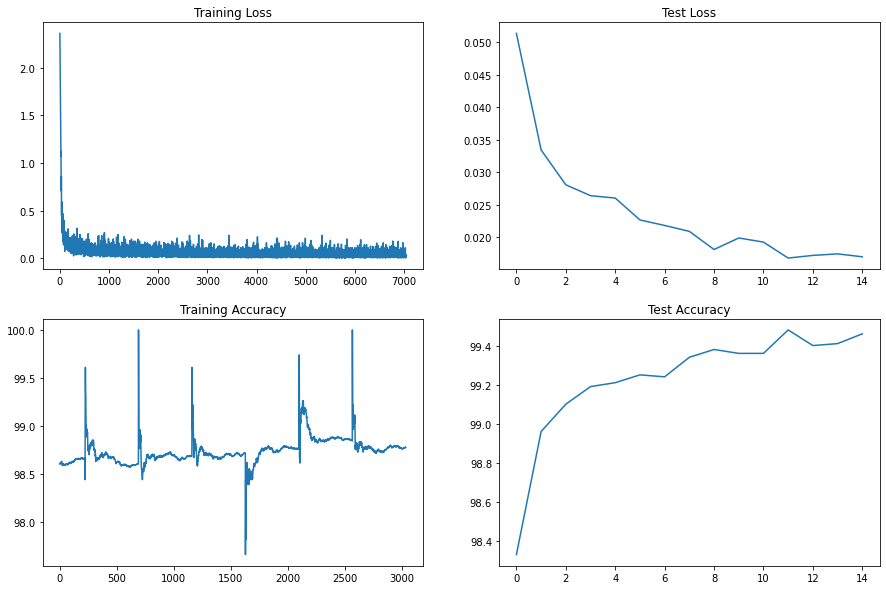

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

#What I did
Made a model with 9.7k parameters

* Ran the model for 50 epochs, with a learning rate of 0.05, the training started with 87.19% of training accuracy. The model eventually reached the accuracy of > 99.40%, highest being 99.49% (At 44th epoch). This means that the model is capable of achieveing higher accuracy given the learning rate is increased.

* Increased the learning rate to 0.01, added image augumentation of 7% tilt and trained the model for 30 epochs. The model started the training with training accuracy of 89.86%. The model managed to achieve >99.40% accuracy on several epochs, started the trend at 19th epochs. The highest the model got the validation accuracy was 99.50% (30th epoch), with training accuracy of 98.78%.

* Increased the learning rate to 0.02, trained the model for 30 epochs. The model started with 91.6367% as the training accuracy. The model first achieved the > 99% validation accuracy at 4th epoch, and continued the upward trend till 8th epoch (This happened before also in the 0.01 learning rate). The model achieved the highest validation accuracy of 99.45% several times (first at 25th epoch)

* Increased the learning rate to 0.04, the model started with 91% of training accuracy and first achieved the validation accuracy of > 99.4% (99.44%) at the 15th epoch. It then continued to overshoot the accuracy multiple times, and come up with the accuracy of > 99.4% again and again. It managed to get the highest validation accuracy of 99.48%.

* Increased the learning rate to 0.08, the model started with 93.3367% of training accuracy. It constantly over-shot the parameters, and was never able achieve the required > 99.4% accuracy. The model continued the forward trend till the 6th epoch, for which it achieved the validation accuracy of 99.17%, and then continued the pattern of rising-falling, and reached highest validation accuracy of 99.25%

* Added a scheduler, with a step size of 7 and gamma of 0.1. The model started with the testing accuracy of 93.3383%. The validation accuracy showed an upward trend till 9th epoch with accuracy of 99.23%, but then it suddenly fell to 99.01% in the next epoch, and continued a linear journey after it. The model was never able to achieve the accuracy beyond 99.4%.

* Changed the schduler with step size of 6 and gamma of 0.125. The model started with the testing accuracy of 93.2700%. The model continued the upward trend till the 6th epoch, where it achieved the validatoin accuracy of 99.22%, but suddenly fell to 99.08% in the next epoch (Hmm, it's seems my model have developed a weird habit of rising and falling, weirdly around the same parameters). Is there something wrong with how scheduler is performing ? The model again reached the validation accuracy of 99.23% at the 11th epoch, and went forward with the highest accuracy of 99.33%.
